In [15]:
import pandas as pd
import os
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt

# Load the font from a file
font_path = os.path.join(os.path.expanduser("~"), '.fonts/Palatino Linotype/palatinolinotype_roman.ttf')  # Replace with the actual path
custom_font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path) 
print(custom_font.get_name())
plt.rcParams["font.family"] = "Palatino Linotype"

Palatino Linotype


In [16]:
STEERING_GOALS = ["reading_difficulty", "textual_diversity", "text_length", "formality"]

# Steerability metric calculation

In [57]:
def scalar_rejection(a, b): # b onto a
    #return np.sqrt(np.linalg.norm(b, axis=1) ** 2 - (np.sum(a * b, axis=1) / (np.linalg.norm(a, axis=1) + 1e-8)) ** 2)
    b_norm = np.sum(b * b, axis=1).values + 1e-8
    proj = (np.sum(a * b, axis=1) / b_norm).values.reshape(-1, 1) * b  # shape [n, d]
    rejection_vec = a - proj
    rejection = np.linalg.norm(rejection_vec, axis=1)
    return rejection

def scalar_projection(a, b):
    return np.sum(a * b, axis=1) / (np.linalg.norm(b, axis=1) + 1e-8)

def get_dist_to_goal(df, by_goal=False, steering_goals=STEERING_GOALS):
    source = df[[f"source_{goal}" for goal in steering_goals]]
    output = df[[f"output_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]]
    target_corrected = target.where(pd.notnull(target), source.values)
    if by_goal:
        dists = pd.DataFrame(target_corrected.values - output.values, columns=steering_goals)
    else:
        dists = np.linalg.norm(output.values - target_corrected.values, axis=1)
    return dists

def get_dist_from_source(df, by_goal=False, steering_goals=STEERING_GOALS): # \hat{z} - z_0
    source = df[[f"source_{goal}" for goal in steering_goals]]
    output = df[[f"output_{goal}" for goal in steering_goals]]           
    if by_goal:
        dists = pd.DataFrame(output.values - source.values, columns=steering_goals)
    else:
        dists = np.linalg.norm(output.values - source.values, axis=1)
    return dists


def get_dist_requested(df, by_goal=False, steering_goals=STEERING_GOALS): # z^* - z_0
    source = df[[f"source_{goal}" for goal in steering_goals]]
    target = df[[f"target_{goal}" for goal in steering_goals]]  
        
    target_corrected = target.where(pd.notnull(target), source.values)
    if by_goal:
        dists = pd.DataFrame(target_corrected.values - source.values, columns=steering_goals)
    else:
        dists = np.linalg.norm(source.values - target_corrected.values, axis=1)
    return dists

def get_orthogonality(df, steering_goals=STEERING_GOALS, normalize=True):
    dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=steering_goals)
    dist_from_goal_actual = get_dist_from_source(df, by_goal=True, steering_goals=steering_goals)
    dist_requested = get_dist_requested(df, by_goal=True, steering_goals=steering_goals)

    dist_from_goal_norm = np.linalg.norm(dist_from_goal_actual, axis=1) 
    dist_requested_norm = np.linalg.norm(dist_requested, axis=1)

    denom = dist_from_goal_norm + 1e-4 * (dist_requested_norm + 1e-8)
    rej = scalar_rejection(dist_to_goal, dist_requested)
    if normalize:
        ortho = np.clip(rej / denom, 0, 1) 
    else:
        ortho = rej
    return ortho


def get_miscalibration(df, steering_goals=STEERING_GOALS, normalize=True):
    dist_to_goal = get_dist_to_goal(df, by_goal=True, steering_goals=steering_goals)
    dist_from_goal_ideal = get_dist_requested(df, by_goal=True, steering_goals=steering_goals)
    denom = np.linalg.norm(dist_from_goal_ideal, axis=1) + 1e-8
    abs_proj_dist = np.abs(scalar_projection(dist_to_goal, dist_from_goal_ideal))
    if normalize:
        miscal = abs_proj_dist / denom
    else:
        miscal = abs_proj_dist 
    return miscal

# Plotting helpers

In [94]:
def preview_samples(df, n=10, topk=None, ranking_function=get_dist_to_goal, steering_goals=STEERING_GOALS):
    def wrap_and_truncate(text):
        if not isinstance(text, str):
            return text
        wrapped = '\n'.join([text[i:i+100] for i in range(0, len(text), 100)])
        return wrapped[:5000] + ('...' if len(text) > 5000 else '')

    with pd.option_context('display.max_colwidth', None):  # Allow full colwidth before manual wrapping
        subset = df.filter(regex="^(text$|instruction$|llm_response|source_(?!text_is_a)|output_(?!raw))", axis=1)
        if topk is None:
            sample = subset.sample(n=n, random_state=42)
            for col in ['text', 'instruction', 'llm_response']:
                if col in sample.columns:
                    sample[col] = sample[col].apply(wrap_and_truncate)
        else:
            print(f"`topk` is not None ({topk}) -- ignoring n.")
            indices = np.argsort(ranking_function(df, steering_goals=steering_goals))
            if topk > 0:
                sample = subset.iloc[indices[:topk]] # best
            else: # negative 
                sample = subset.iloc[indices[topk:]] # worst
        display(sample) 

def fix_violin(violin, color):
    for pc in violin['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        pc.set_zorder(2)

    violin['cbars'].set_color(color) 
    violin['cbars'].set_zorder(1)

    violin['cmeans'].set_color('black')
    violin['cmeans'].set_linewidth(1.)
    violin['cmeans'].set_zorder(2)

    violin['cmins'].set_color('black')  # Minimum horizontal line
    violin['cmins'].set_linewidth(1.)
    violin['cmaxes'].set_color('black')  # Maximum horizontal line
    violin['cmaxes'].set_linewidth(1.)
    violin['cmins'].set_zorder(1)
    violin['cmaxes'].set_zorder(1)

def get_outlier_mask(series):
    lo, hi = np.percentile(series, [2.5, 97.5])
    outlier_mask = (series > hi) | (series < lo)
    return outlier_mask

def create_violin_subplot(data, position, color, ax, scatter_sz=25, text_offset=0.1, fontsize=8):
    outlier_mask = get_outlier_mask(data)
    truncated_data = data[~outlier_mask]
    violin = ax.violinplot(
        truncated_data,
        positions=[position], 
        widths=0.6,
        bw_method=0.2,
        showmeans=True,
    )
    ax.scatter([position] * outlier_mask.sum(), data[outlier_mask], alpha=0.2,
                color=color, marker=".", s=scatter_sz, linewidths=0.5, edgecolor="gray")
    fix_violin(violin, color)
    mean_val = np.mean(data)
    std_val = np.std(data)
    ax.text(
        position, data.max() + text_offset, 
        f"{mean_val:.2f}\n({std_val:.2f})",
        ha="center", va="bottom", fontsize=fontsize, fontweight="bold"
    )


def get_grounded_subset(df, flip=False):
    mask = (df["rationale_approved"] & (df["answer"] == "Yes")) | (~df["rationale_approved"] & (df["answer"] == "No"))
    print(f"{mask.sum()}/{len(df)} rewrites passed groudnedness check")
    if flip:
        mask = ~mask
    return df.loc[mask]

def plot_steerability_metrics(results, colors, names, legend_y, groups=2, per_group=2, control=None,
                          legend_title="Model", save=None, steering_goals=STEERING_GOALS,
                          exclude_degenerate=True,
                          figsize=(10, 2.5)):
    positions = []


    # Calculate positions for each series
    for group_idx in range(groups):
        base = 0.8 * group_idx * (per_group + 1)  # Add spacing between groups
        positions.extend([base + i for i in range(per_group)])

    handles = []

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    axs[0].set_ylabel(r"$\vert\vert \mathbf{\hat{z}} - \mathbf{z}^* \vert\vert_2$")
    axs[1].set_ylabel(r"Miscalibration")
    axs[2].set_ylabel(r"Orthogonality")

    axs[0].set_xlabel("")
    axs[1].set_xlabel("")
    axs[2].set_xlabel("")

    if control is not None:
        control_dist = get_dist_to_goal(control, steering_goals=steering_goals)
        control_miscal = get_miscalibration(control, steering_goals=steering_goals)
        control_ortho = get_orthogonality(control, steering_goals=steering_goals)

    for i, (df, color) in enumerate(zip(results, colors)):
        if exclude_degenerate:
            df = get_grounded_subset(df)
        dist = get_dist_to_goal(df, steering_goals=steering_goals)
        if control is not None:
            dist = dist - control_dist
        create_violin_subplot(dist, positions[i], color, axs[0])

        miscal = get_miscalibration(df, steering_goals=steering_goals)
        if control is not None:
            miscal = miscal - control_miscal
        create_violin_subplot(miscal, positions[i], color, axs[1])

        ortho = get_orthogonality(df, steering_goals=steering_goals)
        if control is not None:
            ortho = ortho - control_ortho
        create_violin_subplot(ortho, positions[i], color, axs[2])

        # for legend
        patch = mpatches.Patch(color=color)
        handles.append(patch)

    for ax in axs:
        ax.tick_params(axis="x", length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim((min(positions) - 1, max(positions) + 1))
        ax.set_xticklabels([])


    if control is not None:
        axs[0].set_ylim((-1.2, 1.))
        axs[1].set_ylim((-3., 4.))
        axs[2].set_ylim((-1, 1.))
        axs[0].hlines([-1.0, -0.5, 0, 0.5, 1.0, 1.5], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[1].hlines([-2., 0., 2., 4.], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[2].hlines([-1., -0.5, 0, 0.5, 1], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
    else:
        axs[0].set_ylim((-0.05, 1.5))
        axs[1].set_ylim((-0.05, 3.))
        axs[2].set_ylim((-0.05, 1.))
        axs[0].hlines([0, 0.4, 0.8, 1.2], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[1].hlines([0, 1, 2, 3], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)
        axs[2].hlines([0, 0.25, 0.5, 0.75, 1], xmin=min(positions) - 1, xmax=max(positions) + 1, color="#000000", alpha=0.1, zorder=-999)

    #fig.suptitle(suptitle)
    lgd = fig.legend(
        handles,
        names, # + ["Perfect steerability"],
        ncols=min(len(results) + 1, 5),
        loc="lower center",
        bbox_to_anchor=(0.5, legend_y),
        title=legend_title,
    )
    fig.tight_layout()
    if save is not None:
        fig.savefig(f"figures/{save}.pdf", bbox_inches="tight", bbox_extra_artists=(lgd, sup))
    fig.show()



2047/2048 rewrites passed groudnedness check


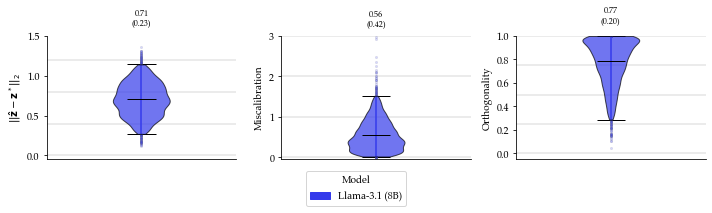

In [95]:
llama_results = pd.read_csv("judge_results/grounding/v2.1_llama3.1_8b_judged.csv", index_col=0)
llama3_1_color = "#343aeb"

plot_steerability_metrics(
    [llama_results],
    [llama3_1_color],
    ["Llama-3.1 (8B)"],
    -0.2,
    groups=1,
    per_group=1,
)

# Goal flow diagrams

In [109]:
from scipy.interpolate import griddata

def grab_subspace(df, *args, unspecified=True, specified_first=False):
    xy = df[[f"source_{g}" for g in args]] # can also ask for deltas
    source_df = get_dist_from_source(df, by_goal=True)
    dxdy = source_df[list(args)] # output - source
    dxdy_ideal = get_dist_requested(df, by_goal=True)[list(args)].fillna(0.)
    
    dxdy.columns = [f"d_{g}" for g in args]
    dxdy_ideal.columns = [f"d*_{g}" for g in args]
    final = pd.concat([xy, dxdy, dxdy_ideal], axis=1)
    if unspecified:
        final = final.loc[dxdy_ideal.sum(axis=1) == 0]
    elif specified_first:
        final = final.loc[(dxdy_ideal[f"d*_{args[0]}"].abs() > 0) & (dxdy_ideal[f"d*_{args[1]}"] == 0)] # TODO: make this work for >1 goal
    final.columns = ["x1", "x2", "dx1", "dx2", "dx1_ideal", "dx2_ideal"]
    return final

def flow_diagram(df, xname, yname, unspecified=False, specified_first=True, model_display_name=None,
                 mode="movement", drop_close=None, save=False):
    if mode not in ["movement", "distance_to_goal"]:
        raise ValueError(f"Unuspported mode: {mode}")

    if mode == "movement":
        name = "Movement"
    else:
        name = "Distance to goal"
    
    subspace = grab_subspace(df, xname, yname, unspecified=unspecified, specified_first=specified_first)
    
    # Create a subplot with two plots: raw data and interpolated data
    fig, axes = plt.subplots(1, 2, figsize=(6, 2.7))
    suptitle = f"Steering errors in ({xname}, {yname})-subspace "
    if model_display_name is not None:
        suptitle += f"\nModel: {model_display_name}"
    fig.suptitle(suptitle, y=0.9)
    
    xlabel = f"{xname} (active)"
    ylabel = f"{yname} (inactive)"

    z0_size = 10
    z0_color = "#fa5fbb"
    movement_color = "#ed492b"
    rawwidth = 5
    headwidth = 5
    arrowwidth = 0.004
    flow_width = 0.005
    
    axes[0].scatter(subspace["x1"], subspace["x2"], marker=".", alpha=0.5, edgecolors=z0_color, facecolors="none", s=z0_size)
    if mode == "movement":
        axes[0].quiver(subspace["x1"], subspace["x2"], subspace["dx1"], subspace["dx2"], scale=5, 
                   color=movement_color, alpha=0.9, headwidth=rawwidth, width=arrowwidth)
    else:
        x1, x2 = subspace["x1"], subspace["x2"]
        dx1, dx2 = subspace["dx1_ideal"] - subspace["dx1"], subspace["dx2_ideal"] - subspace["dx2"]
        if drop_close is not None:
            err_norm = np.sqrt(dx1 ** 2 + dx2 ** 2)
            err_mask = err_norm > drop_close
            x1, x2, dx1, dx2 = x1[err_mask], x2[err_mask], dx1[err_mask], dx2[err_mask]
        
        axes[0].quiver(x1, x2, dx1, dx2, scale=10, color=movement_color,
                       alpha=0.9, headwidth=rawwidth, width=arrowwidth)
    
    axes[0].set_title(f"{name} (observed)")
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    axes[0].set_xlim((0, 1))
    axes[0].set_ylim((0, 1))
    axes[0].grid(True)


    grid_x, grid_y = np.meshgrid(np.linspace(min(subspace["x1"]), max(subspace["x1"]), 20),
                                 np.linspace(min(subspace["x2"]), max(subspace["x2"]), 20))

    if mode == "movement":
        grid_u = griddata((subspace["x1"], subspace["x2"]), subspace["dx1"], (grid_x, grid_y), method='linear')
        grid_v = griddata((subspace["x1"], subspace["x2"]), subspace["dx2"], (grid_x, grid_y), method='linear')
    else:
        grid_u = griddata((subspace["x1"], subspace["x2"]), subspace["dx1_ideal"] - subspace["dx1"], (grid_x, grid_y), method='linear')
        grid_v = griddata((subspace["x1"], subspace["x2"]), subspace["dx2_ideal"] - subspace["dx2"], (grid_x, grid_y), method='linear')

    
    # Plot the interpolated data
    axes[1].scatter(subspace["x1"], subspace["x2"], marker=".", alpha=0.5,
                    edgecolors=z0_color, facecolors="none", s=z0_size)

    axes[1].quiver(grid_x, grid_y, grid_u, grid_v, scale=5, color='#3061ff', headwidth=headwidth, width=flow_width, alpha=0.9)
    axes[1].set_title(f"{name} (interpolated)")
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)
    axes[1].set_xlim((0, 1))
    axes[1].set_ylim((0, 1))
    axes[1].grid(True)

    plt.tight_layout()
    if save:
        plt.savefig(f"flow_{xname}_{yname}_subspace.pdf")
    plt.show()
    return subspace


from itertools import product

def get_pairwise_flows(df, steering_goals=STEERING_GOALS):
    for x, y in product(steering_goals, steering_goals):
        if x != y:
            flow_diagram(df, x, y, specified_first=True, unspecified=False, mode="movement")

    

In [102]:
%debug

> /data2/ctrenton/miniconda3/envs/steerability/lib/python3.9/site-packages/pandas/core/indexing.py(1418)_getitem_axis()
   1416             if not (isinstance(key, tuple) and isinstance(labels, MultiIndex)):
   1417                 if hasattr(key, "ndim") and key.ndim > 1:
-> 1418                     raise ValueError("Cannot index with multidimensional key")
   1419 
   1420                 return self._getitem_iterable(key, axis=axis)

> /data2/ctrenton/miniconda3/envs/steerability/lib/python3.9/site-packages/pandas/core/indexing.py(1191)__getitem__()
   1189             maybe_callable = com.apply_if_callable(key, self.obj)
   1190             maybe_callable = self._check_deprecated_callable_usage(key, maybe_callable)
-> 1191             return self._getitem_axis(maybe_callable, axis=axis)
   1192 
   1193     def _is_scalar_access(self, key: tuple):

> <ipython-input-100-c00a3b7286dc>(15)grab_subspace()
     13         final = final.loc[dxdy_ideal.sum(axis=1) == 0]
     14     elif s

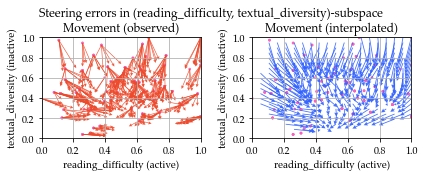

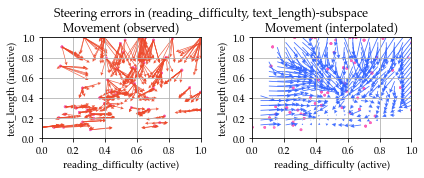

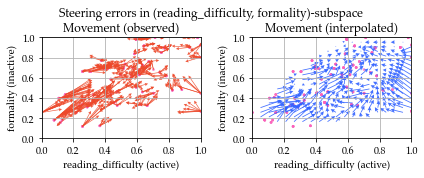

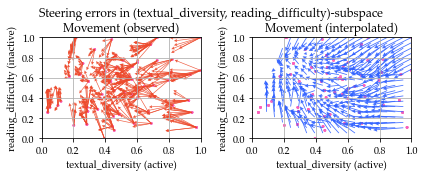

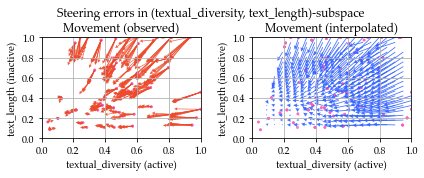

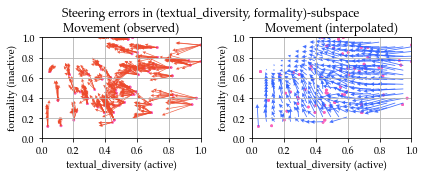

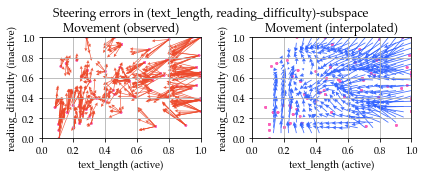

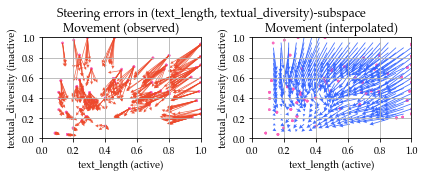

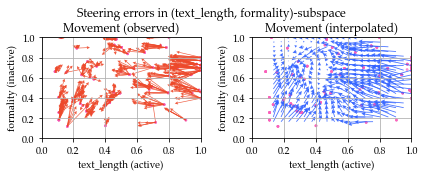

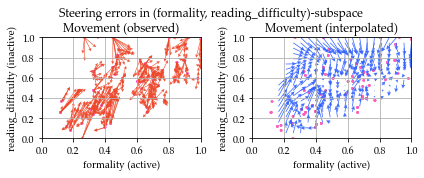

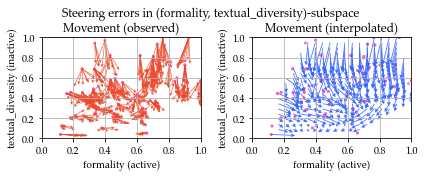

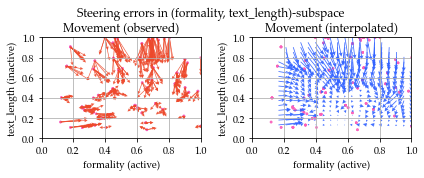

In [111]:
get_pairwise_flows(llama_results)

# Scratch

In [73]:
ortho_unnorm = get_orthogonality(llama_results, normalize=False)
miscal_unnorm = get_miscalibration(llama_results, normalize=False)
error = get_dist_to_goal(llama_results)

error

array([0.69357813, 0.52157058, 1.09247875, ..., 1.01950701, 0.56626523,
       0.74339149])

In [74]:
(np.sqrt(ortho_unnorm ** 2 + miscal_unnorm ** 2) - error).describe()

count    2.048000e+03
mean    -3.616249e-09
std      3.810676e-09
min     -2.607063e-08
25%     -5.516919e-09
50%     -2.310705e-09
75%     -6.026141e-10
max      5.551115e-17
dtype: float64

In [91]:
get_grounded_subset(llama_results, flip=True)

2047 rewrites passed groudnedness check


,original_index,text,source,reading_difficulty,textual_diversity,text_length,formality,source_reading_difficulty,source_textual_diversity,source_text_length,...,version_a,version_b,source_text_is_a,prompt,raw_judge_output,clean_judge_output,answer,rationale,rationale_approved,spot_check
2038,3275,God help\nthe noble Claudio! If he have caught...,Dataset: kmfoda/booksum/validation,2.4,77.90736,235.0,47.740113,0.0,0.395022,0.109713,...,God help\nthe noble Claudio! If he have caught...,"Alas, may Providence intervene on behalf of th...",True,You are an impartial judge comparing two texts...,"{\n ""answer"": No,\n ""rationale"": ""The tw...","{\n ""answer"": No,\n ""rationale"": ""The tw...",No,The two texts are not variations of the same t...,True,True


In [57]:
preview_samples(llama_results, topk=-5)

`topk` is not None (-5) -- ignoring n.


,text,source_reading_difficulty,source_textual_diversity,source_text_length,source_formality,instruction,llm_response,output_reading_difficulty,output_textual_diversity,output_text_length,output_formality
233,"His poppy-colored cheeks were distended with his first big bite of\nbread and bacon, but he managed to smile encouragingly. ""If tha' was a missel thrush an' showed me where thy nest was, does\ntha' think I'd tell any one? Not me,"" he said. ""Tha' art as safe as a\nmissel thrush."" And she was quite sure she was.",0.039604,0.938383,0.000000,0.276922,"Please rewrite the following, but make it much more formal, much longer, and use less diverse language. Respond with only the rewritten text and do not explain your response.","As he partook of his initial substantial morsel of bread and bacon, the vibrant hue of his cheeks became noticeably more pronounced, yet he endeavored to maintain a countenance of encouragement. ""If, in the event that you were a missel thrush and were to reveal to me the location of your nest, do you believe that I would be inclined to disclose such information to anyone else?"" he inquired, his tone bespeaking a sense of solemnity and unwavering commitment to confidentiality. ""I daresay, not I,"" he continued, his words imbued with a sense of conviction and reassurance. ""You are as secure as a missel thrush, and I assure you that your trust in me shall be reciprocated with unwavering loyalty and discretion."" And, indeed, she was thoroughly convinced of her safety, her confidence bolstered by the sincerity and reliability that emanated from his words.",0.980198,0.170803,0.062893,0.564364
1346,"this was a few days after christmas where my mom, when my mom made mac and cheese, which was a lot that she made. i didn't have any because i don't really like it. than i told her that i haven't have really good mac and cheese. than we started to playfully argue that why i didn't taste hers. i told her because of school and i didn't want to sleep late, it was about 12. we had to go home, and i had to wake up at four. so i didn't take any,....yeah i just fucked up.",0.059406,0.019012,0.027254,0.000000,"Please rewrite the following, but make it longer, use much more diverse language, and harder to read. Respond with only the rewritten text and do not explain your response.","It was a few days subsequent to the festive holiday of Christmas, a period during which my maternal figure, in a gesture of culinary benevolence, had prepared an abundance of macaroni and cheese, a dish that, regrettably, I had opted not to partake in due to my somewhat fastidious gastronomical inclinations. However, in a moment of candor, I did confess to my mother that, in all honesty, I had yet to experience a truly exceptional macaroni and cheese, one that would elevate this humble dish to an unprecedented plane of gastronomical nirvana. This innocuous statement, however, precipitated a lighthearted yet spirited debate, wherein my mother playfully interrogated me as to why I had declined the opportunity to sample her culinary masterpiece. I responded, with a mixture of sincerity and pragmatism, that my academic obligations, coupled with the imperative to maintain a regular sleep schedule, had necessitated an early departure from our domicile, with a wake-up call scheduled for the ungodly hour of four in the morning. Consequently, I had elected not to partake in the macaroni and cheese, a decision that, in retrospect, I now realize was a grave error of judgment, a culinary faux pas of monumental proportions, one that would haunt me for the remainder of the day.",1.000000,0.147199,0.113208,0.878892
248,"His poppy-colored cheeks were distended with his first big bite of\nbread and bacon, but he managed to smile encouragingly. ""If tha' was a missel thrush an' showed me where thy nest was, does\ntha' think I'd tell any one? Not me,"" he said. ""Tha' art as safe as a\nmissel thrush."" And she was quite sure she was.",0.039604,0.938383,0.00

In [78]:
llama_results[llama_results["rationale_approved"] & (llama_results["answer"] == "Yes")]

,original_index,text,source,reading_difficulty,textual_diversity,text_length,formality,source_reading_difficulty,source_textual_diversity,source_text_length,...,version_a,version_b,source_text_is_a,prompt,raw_judge_output,clean_judge_output,answer,rationale,rationale_approved,spot_check
0,2165,"David Cameron, William Hague and Michael Gove ...",Dataset: ccdv/cnn_dailymail/3.0.0/validation,10.7,113.579724,1224.0,58.180987,0.782178,0.821215,0.800839,...,"David Cameron, William Hague and Michael Gove ...","Yesterday, a plot by the Conservatives to remo...",True,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...",Yes,"Both texts describe the same event, a failed C...",True,False
1,2165,"David Cameron, William Hague and Michael Gove ...",Dataset: ccdv/cnn_dailymail/3.0.0/validation,10.7,113.579724,1224.0,58.180987,0.782178,0.821215,0.800839,...,"David Cameron, William Hague, and Michael Gove...","David Cameron, William Hague and Michael Gove ...",False,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...",Yes,"Both texts describe the same event, an attempt...",True,False
2,2165,"David Cameron, William Hague and Michael Gove ...",Dataset: ccdv/cnn_dailymail/3.0.0/validation,10.7,113.579724,1224.0,58.180987,0.782178,0.821215,0.800839,...,So the Tories got totally owned last night aft...,"David Cameron, William Hague and Michael Gove ...",False,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...",Yes,"Both texts describe the same event, a failed T...",True,False
3,2165,"David Cameron, William Hague and Michael Gove ...",Dataset: ccdv/cnn_dailymail/3.0.0/validation,10.7,113.579724,1224.0,58.180987,0.782178,0.821215,0.800839,...,"David Cameron, William Hague, and Michael Gove...","David Cameron, William Hague and Michael Gove ...",False,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Both te...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Both te...",Yes,"Both texts describe the same event, an attempt...",True,False
4,2165,"David Cameron, William Hague and Michael Gove ...",Dataset: ccdv/cnn_dailymail/3.0.0/validation,10.7,113.579724,1224.0,58.180987,0.782178,0.821215,0.800839,...,"David Cameron, William Hague and Michael Gove ...",Tory MPs led a failed attempt to remove Common...,True,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Bot...",Yes,"Both texts describe the same event, a failed a...",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,3275,God help\nthe noble Claudio! If he have caught...,Dataset: kmfoda/booksum/validation,2.4,77.907360,235.0,47.740113,0.000000,0.395022,0.109713,...,God help\nthe noble Claudio! If he have caught...,May the benevolent deity extend its benevolenc...,True,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Both te...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Both te...",Yes,Both texts appear to be describing the same sc...,True,False
2044,3275,God help\nthe noble Claudio! If he have caught...,Dataset: kmfoda/booksum/validation,2.4,77.907360,235.0,47.740113,0.000000,0.395022,0.109713,...,May Providence intervene on behalf of the este...,God help\nthe noble Claudio! If he have caught...,False,You are an impartial judge comparing two texts...,"{\n ""answer"": ""Yes"",\n ""rationale"": ""Both te...","{\n ""answer"": ""Yes"",\n ""rationale"": ""Both te...",Yes,Both texts appear to be describing the same sc...,True,False
2045,3275,God help\nthe noble Claudio! If he have caught...,Dataset: kmfoda/booksum/validation,2.4,77.907360,235.0,47.740113,0.000000,0.

In [11]:
from taaled import ld

text1 = 'His poppy-colored cheeks were distended with his first big bite of\nbread and bacon, but he managed to smile encouragingly. "If tha\' was a missel thrush an\' showed me where thy nest was, does\ntha\' think I\'d tell any one? Not me," he said. "Tha\' art as safe as a\nmissel thrush." And she was quite sure she was.'
text2 = (
    "His poppy-hued countenance, a vibrant testament to the unbridled joy that coursed through his being, was momentarily distorted by the sheer magnitude of his inaugural "
    "bite of the crispy, golden-brown bread and the savory, smoky bacon that lay nestled within, yet he somehow managed to muster a smile of unbridled encouragement, a beaming "
    "countenance that seemed to radiate an aura of unwavering optimism, as if to reassure her that all was indeed well. \"If, hypothetically speaking, thou wert a missel thrush, "
    "and thou didst deign to reveal to me the location of thy humble abode, I daresay I would not be so crass as to betray thy trust, nay, not I,\" he declared, his words dripping "
    "with an air of feigned nonchalance, as if to convey a sense of utter sincerity, \"for I am a man of my word, a paragon of virtue, and a stalwart defender of the innocent, and I "
    "would not dream of compromising thy safety, no, not for all the world.\" And she was quite, quite certain that she was safe, that she had found a true ally in this rugged, yet "
    "endearing individual, a man who seemed to possess a heart of gold, and a tongue that was as smooth as silk, and as persuasive as a summer breeze on a warm, languid afternoon."
)

ldvals = ld.lexdiv(text1)
ldvals.mtld

219.52000000000015

In [12]:
clean = lats.Normalize(text1, lats.ld_params_en)
ldvals = ld.lexdiv(clean.toks)
ldvals.mtld


78.49333333333335

In [13]:
lats.__file__

'/data2/ctrenton/miniconda3/envs/steerability/lib/python3.9/site-packages/pylats/lats.py'

In [6]:
from pylats import lats
from taaled import ld


In [3]:
!python -m spacy download es_core_news_sm
!python -m spacy download es_dep_news_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 39.4 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 MB 20.4 MB/s eta 0:00:0000:0100:01
  Using cached spacy_curated_transformers-0.2.2-py2.py3-none-any.whl.metadata (2.7 kB)
Using cached spacy_curated_transformers-0.2.2-py2.py3-none-any.whl (236 kB)
  Attempting uninstall: spacy-curated-transformers
    Found existing installation: spacy-curated-transformers 0.3.0
    Uninstalling spacy-curated-transformers-0.3.0:
      Successfully uninstalled spacy-curated-transformers-0.3.0
✔ Download and installation successful
You can now load the package via spacy.load('es_dep_news_trf')
